This script is used to produce AUC curve

For poses file \n
The folder 'poses' contains the ground truth poses (trajectory) for the
first 11 sequences. This information can be used for training/tuning your
method. Each file xx.txt contains a N x 12 table, where N is the number of
frames of this sequence. Row i represents the i'th pose of the left camera
coordinate system (i.e., z pointing forwards) via a 3x4 transformation
matrix. The matrices are stored in row aligned order (the first entries
correspond to the first row), and take a point in the i'th coordinate
system and project it into the first (=0th) coordinate system. Hence, the
translational part (3x1 vector of column 4) corresponds to the pose of the
left camera coordinate system in the i'th frame with respect to the first
(=0th) frame. Your submission results must be provided using the same data
format.

**Let's process groundtruth pose**

**MobileNet vs ResNet vs ViT-base vs Dino vs mobileViT vs..**
None of them are finetuned for place recognition?
VPR-MobileViT?

In [1]:
import numpy as np

# Load the ground truth file
def load_poses(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    poses = []
    for line in lines:
        values = list(map(float, line.split()))
        # Convert each line to a 3x4 matrix
        pose_matrix = np.array(values).reshape(3, 4)
        poses.append(pose_matrix)

    return np.array(poses)

# Calculate relative transformations between two poses
def relative_transform_mycode(pose1, pose2):
    R1, t1 = pose1[:, :3], pose1[:, 3]
    R2, t2 = pose2[:, :3], pose2[:, 3]

    # Relative rotation and translation
    R_rel = R2.T @ R1 #very close to I if same orientation
    # t_rel = R2.T@(t1-t2) #translation error just substract
    t_rel = t1-t2 #translation error just substract

    return R_rel, t_rel

# Check if two poses are similar within a given threshold (loop closure criterion)
def is_loop_closure_mycode(R_rel, t_rel, rot_thresh=0.1, trans_thresh=0.1):
    # Check translation threshold
    trans_error = np.linalg.norm(t_rel)

    # Early stop to speed up
    if trans_error >= trans_thresh:
        return False

    # Check rotation threshold using angle of rotation (trace method)
    trace_val = np.trace(R_rel)
    rot_error = np.arccos((trace_val - 1) / 2) # Radians, the rot_error is angle scalar value for axis-angle representaion of the rotation

    return trans_error < trans_thresh and rot_error < rot_thresh

# Find loop closure pairs with temporal consistency
# early_stop = -1 means no early stop, or else stop at the epoch
def find_loop_closures_mycode(poses, 
                              min_frame_gap=30, 
                              rot_thresh=0.1, 
                              trans_thresh=0.1, 
                              early_stop=-1):
    """
    Scans all pairs of poses (i, j) from the given sequence and identifies
    loop closures based on rotation and translation thresholds.

    Parameters
    ----------
    poses : list
        A list of poses (e.g., 4x4 transformation matrices or similar) for each frame.
    min_frame_gap : int, optional
        The minimum gap in frame indices to consider as a valid loop closure pair.
        Frames closer than this gap are ignored. Default is 30.
    rot_thresh : float, optional
        The maximum allowed rotation difference to classify a pair as a loop closure. Default is 0.1.
    trans_thresh : float, optional
        The maximum allowed translation difference to classify a pair as a loop closure. Default is 0.1.
    early_stop : int, optional
        If set to a non-negative integer, stops checking for loop closures after reaching this frame index.
        Useful for debugging or limiting runtime. Default is -1 (i.e., no early stop).

    Returns
    -------
    loop_closures : list of tuples
        Each element is a tuple (i, j), indicating that frames i and j form a loop closure.

    Notes
    -----
    - This function relies on two helper functions:
        1) relative_transform_mycode(poses[i], poses[j]) -> (R_rel, t_rel)
        2) is_loop_closure_mycode(R_rel, t_rel, rot_thresh, trans_thresh) -> bool
      to compute the relative transformation and to test the loop closure condition.
    - This brute-force approach has O(N^2) complexity for N frames, so it may be slow for large N.
    """

    loop_closures = []
    num_poses = len(poses)

    for i in range(num_poses):
        if early_stop != -1 and i >= early_stop:
            break
        if i % 100 == 0:
            print(f"Processing frame {i} out of {num_poses}")

        # for j in range(i, num_poses):
        for j in range(num_poses):
            # Skip if frames are too close
            if abs(i - j) <= min_frame_gap:
                continue

            # Calculate the relative transformation
            R_rel, t_rel = relative_transform_mycode(poses[i], poses[j])

            # Check if it meets the loop closure criteria
            if is_loop_closure_mycode(R_rel, t_rel, rot_thresh, trans_thresh):
                loop_closures.append((i, j))

    return loop_closures



In [2]:
file_path = '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_poses/dataset/poses/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)   #A 3*4 homogeneous matrix for pose representation
R_rel, t_rel = relative_transform_mycode(poses[100], poses[3000])
trace_val = np.trace(R_rel)
rot_error = np.arccos((trace_val - 1) / 2)
trace_val

-0.49839149492920176

In [3]:
R_rel

array([[-0.74918526, -0.02054693,  0.66204166],
       [ 0.02910192,  0.99753237,  0.06389168],
       [-0.6617209 ,  0.0671334 , -0.74673861]])

In [4]:
# Set up your parameters and load the file
file_path = '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_poses/dataset/poses/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)

# Find loop closure pairs with a minimum frame gap of 100 frames (5 seconds)
min_frame_gap = 100
rot_thresh = 0.3  # Rotation threshold in radians, 0.3 radian == 17.18 degree
trans_thresh = 1.5  # Translation threshold in meters
loop_closures = find_loop_closures_mycode(poses, min_frame_gap, rot_thresh, trans_thresh, early_stop = -1)

# Output the loop closures
print(f'We found {len(loop_closures)} pairs')
print("Loop Closure Pairs (Frame i, Frame j):")
for i, j in loop_closures:
    print(f"Frame {i} - Frame {j}")


Processing frame 0 out of 4541
Processing frame 100 out of 4541
Processing frame 200 out of 4541
Processing frame 300 out of 4541
Processing frame 400 out of 4541
Processing frame 500 out of 4541
Processing frame 600 out of 4541
Processing frame 700 out of 4541
Processing frame 800 out of 4541
Processing frame 900 out of 4541
Processing frame 1000 out of 4541
Processing frame 1100 out of 4541
Processing frame 1200 out of 4541
Processing frame 1300 out of 4541
Processing frame 1400 out of 4541
Processing frame 1500 out of 4541
Processing frame 1600 out of 4541
Processing frame 1700 out of 4541
Processing frame 1800 out of 4541
Processing frame 1900 out of 4541
Processing frame 2000 out of 4541
Processing frame 2100 out of 4541
Processing frame 2200 out of 4541
Processing frame 2300 out of 4541
Processing frame 2400 out of 4541
Processing frame 2500 out of 4541
Processing frame 2600 out of 4541
Processing frame 2700 out of 4541
Processing frame 2800 out of 4541
Processing frame 2900 out 

In [5]:
poses[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16]])

In [6]:
len(loop_closures)

6044

In [7]:
# Write loop_closures list into a txt file one element per line
with open('loop_closures_ground_truth.txt', 'w') as f:
    for i, j in loop_closures:
        f.write(f"{i} {j}\n")

**Parse groundtruth**

In [10]:
# Step 1: Import required libraries
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Parse the ground truth loop closure file
def parse_ground_truth(file_path):
    """Parses the ground truth file to extract loop closure pairs."""
    ground_truth = defaultdict(set)  # {query_id: {true_matches, ...}}

    with open(file_path, 'r') as f:
        for line in f:
            query_id, match_id = map(int, line.strip().split())
            ground_truth[query_id].add(match_id)
    return ground_truth


**Now Let's parse NetVLAD result(with or w/o faiss)**

In [11]:
import re
from collections import defaultdict

def parse_netvlad_results(file_path, exclusion_range=100):
    """
    Parses the NetVLAD loop closure query results file to extract image matches,
    excluding candidates within ±exclusion_range of the query index, 100 range == 5 seconds

    Args:
        file_path (str): Path to the NetVLAD results file.
        exclusion_range (int): The range of indices around the query to exclude.

    Returns:
        dict: Dictionary where the key is query_id and the value is a list of (candidate_id, distance) tuples.
    """
    netvlad_results = defaultdict(list)  # {query_id: [(candidate_id, distance), ...]}

    with open(file_path, 'r') as f:
        current_query = None
        for line in f:
            # Check for the start of a new query section
            match = re.match(r"Top \d+ most similar images to (\d+).png:", line.strip())
            if match:
                current_query = int(match.group(1))
                continue

            # Check for the image and distance entry
            match = re.match(r"\s*\d+\.\s+(\d+).png\s*-\s*Euclidean Distance:\s*([0-9.]+)", line.strip())
            if match:
                candidate_id = int(match.group(1))
                distance = float(match.group(2))

                # Filter out candidates within ±exclusion_range of the query
                if current_query is not None and abs(candidate_id - current_query) > exclusion_range:
                    netvlad_results[current_query].append((candidate_id, distance))
                else:
                    # If filtering them out, just skip adding them.
                    # If no valid candidates exist, skip
                    pass
            else:
                # Uncomment this line to debug unparsed lines
                # print(f"Unparsed line: {line.strip()}")
                pass

    if len(netvlad_results) == 0:
        print("Warning: No entries were parsed from the NetVLAD results file.")
    else:
        print(f"Parsed {len(netvlad_results)} query entries successfully.")
    return netvlad_results


In [22]:
import re
from collections import defaultdict

def parse_dbow_results(file_path, exclusion_range=100):
    """
    Parses the DBoW loop closure query results file to extract image matches,
    excluding candidates within ±exclusion_range of the query index.

    Args:
        file_path (str): Path to the DBoW results file.
        exclusion_range (int): The range of indices around the query to exclude.

    Returns:
        dict: Dictionary where the key is query_id and the value is a list of (candidate_id, score) tuples.
    """
    dbow_results = defaultdict(list)  # {query_id: [(candidate_id, score), ...]}

    with open(file_path, 'r') as f:
        current_query = None
        for line in f:
            # Check for the start of a new query section
            match = re.match(r"Top \d+ most similar images to (\d+).png:", line.strip())
            if match:
                current_query = int(match.group(1))
                continue

            # Check for the image and score entry
            match = re.match(r"<EntryId:\s*(\d+),\s*Score:\s*([0-9.]+)>", line.strip())
            if match:
                candidate_id = int(match.group(1))
                score = float(match.group(2))

                # Filter out candidates within ±exclusion_range of the query
                if current_query is not None and abs(candidate_id - current_query) > exclusion_range:
                    dbow_results[current_query].append((candidate_id, score))
                else:
                    # If filtering them out, just skip adding them.
                    pass
            else:
                # Uncomment this line to debug unparsed lines
                # print(f"Unparsed line: {line.strip()}")
                pass

    if len(dbow_results) == 0:
        print("Warning: No entries were parsed from the DBoW results file.")
    else:
        print(f"Parsed {len(dbow_results)} query entries successfully.")
    
    return dbow_results

# Example usage:
dbow_results_file = "dbow_result_large.txt"
dbow_results = parse_dbow_results(dbow_results_file)
dbow_results[0]

Parsed 4527 query entries successfully.


[(4451, 0.0267537),
 (4449, 0.0208412),
 (4450, 0.0206372),
 (4447, 0.0181913),
 (4440, 0.0148144),
 (126, 0.0144707),
 (4448, 0.0131416),
 (572, 0.0125454),
 (3133, 0.0118798),
 (557, 0.0118205),
 (3507, 0.0116677),
 (2029, 0.0115878),
 (2586, 0.011429),
 (559, 0.0113235),
 (4453, 0.0112919),
 (2993, 0.0112544),
 (4454, 0.011246),
 (785, 0.0111815),
 (426, 0.0110713),
 (4438, 0.0110573),
 (2921, 0.0109722),
 (3573, 0.0109635),
 (4361, 0.0109526),
 (550, 0.0108048),
 (4452, 0.0107818),
 (1524, 0.0107762),
 (2279, 0.010767),
 (761, 0.0107407),
 (1313, 0.0104822),
 (1622, 0.0102677),
 (1499, 0.0101829),
 (3922, 0.0100638),
 (1480, 0.0100607),
 (942, 0.0100581),
 (574, 0.0100142),
 (1620, 0.00997342),
 (3763, 0.0098068),
 (4458, 0.00963392),
 (4446, 0.00962155),
 (3865, 0.00959299),
 (2367, 0.00959014),
 (4455, 0.00957415)]

In [15]:
#Let's check the result for image 0, check netvlad_result.txt for validation

netvlad_results = parse_netvlad_results('./netvlad_result_faiss_large.txt')
# netvlad_results = parse_netvlad_results('./netvlad_result_faiss.txt')
# netvlad_results = parse_netvlad_results('./netvlad_result.txt')

Parsed 4226 query entries successfully.


**We have netvlad result and ground truth result, now we can cross-validate and remove the false positives & plot AUC curve**

In [16]:
netvlad_results[0] #Not Many false positives for 0 query

[(4450, 0.7884),
 (4451, 0.8338),
 (4452, 0.8666),
 (4449, 0.8718),
 (4448, 0.9182),
 (4454, 0.9182),
 (4453, 0.9222),
 (4447, 0.9372),
 (4455, 0.9539),
 (4446, 0.9836),
 (4536, 1.0015),
 (4445, 1.0044),
 (4531, 1.0052),
 (4533, 1.0082),
 (4532, 1.0086),
 (4534, 1.0098),
 (4483, 1.0124),
 (4457, 1.0172),
 (4537, 1.0192),
 (4484, 1.0223),
 (4470, 1.0239),
 (4539, 1.0254),
 (4535, 1.0273),
 (4482, 1.0295),
 (4538, 1.0303),
 (1998, 1.0306),
 (4460, 1.0313),
 (4463, 1.0317),
 (4459, 1.0319),
 (4443, 1.0325),
 (4473, 1.0329),
 (4471, 1.0343)]

In [18]:
ground_truth = parse_ground_truth('./loop_closures_ground_truth.txt')
ground_truth

defaultdict(set,
            {0: {4448},
             1: {4449, 4450},
             2: {4449, 4450, 4451},
             3: {4449, 4450, 4451, 4452},
             4: {4451, 4452, 4453, 4454},
             5: {4452, 4453, 4454, 4455},
             6: {4453, 4454, 4455, 4456},
             7: {4454, 4455, 4456, 4457},
             8: {4455, 4456, 4457, 4458},
             9: {4457, 4458, 4459},
             10: {4458, 4459, 4460},
             11: {4459, 4460, 4461},
             12: {4460, 4461, 4462},
             13: {4461, 4462, 4463},
             14: {4462, 4463, 4464},
             15: {4463, 4464, 4465},
             16: {4464, 4465, 4466},
             17: {4465, 4466, 4467},
             18: {4466, 4467, 4468},
             19: {4467, 4468, 4469},
             20: {4468, 4469, 4470},
             21: {4469, 4470, 4471},
             22: {4470, 4471, 4472},
             23: {4471, 4472, 4473},
             24: {4472, 4473, 4474},
             25: {4473, 4474, 4475},
             

precision = TP / (TP + FP) \
recall = TP / (TP + FN) \
precision is a measure of the fraction of relevant items among actually returned items while recall is a measure of the fraction of items that were returned among all items that should have been returned.


The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. 

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. This ensures that the graph starts on the y axis.

The first precision and recall values are precision=class balance and recall=1.0 which corresponds to a classifier that always predicts the positive class.

### Re-write precision-recall curve with sklearn 

In [24]:
ground_truth[4500]

{53, 54, 55}

In [23]:
dbow_results[4500]

[(54, 0.0730614),
 (53, 0.0502942),
 (55, 0.0462538),
 (52, 0.0423934),
 (50, 0.0306193),
 (51, 0.02816),
 (56, 0.0254402),
 (62, 0.0217428),
 (49, 0.0213845),
 (57, 0.0211618),
 (48, 0.0202563),
 (63, 0.0187525),
 (47, 0.0177163),
 (58, 0.0176145),
 (104, 0.0170902),
 (2152, 0.0168993),
 (2163, 0.0154902),
 (65, 0.0149099),
 (2426, 0.0148419),
 (59, 0.0148273),
 (852, 0.0146041),
 (41, 0.0144371),
 (3366, 0.0143825),
 (2110, 0.0140527),
 (45, 0.0139802),
 (3380, 0.0137433),
 (2156, 0.0134367),
 (2137, 0.0132861),
 (3891, 0.0131986),
 (2428, 0.0128808),
 (2422, 0.0128361),
 (1978, 0.0127757),
 (60, 0.0127201)]

In [25]:
netvlad_results[4500]

[(54, 0.5518),
 (55, 0.6631),
 (53, 0.6772),
 (56, 0.79),
 (52, 0.8422),
 (57, 0.8618),
 (59, 0.9206),
 (50, 0.9241),
 (49, 0.9271),
 (61, 0.9301),
 (58, 0.9302),
 (51, 0.9334),
 (60, 0.9432),
 (48, 0.9549),
 (62, 0.9561),
 (34, 0.9593),
 (35, 0.965),
 (33, 0.9749),
 (3612, 0.9769),
 (36, 0.9825),
 (3621, 0.9846),
 (3602, 0.9876),
 (673, 0.9877),
 (29, 0.9886),
 (63, 0.9921),
 (647, 0.9923),
 (649, 0.9965),
 (22, 0.9973),
 (3596, 0.9976)]

In [26]:
ground_truth[396]

{2448, 2449, 2450, 2451, 3398, 3399, 3400, 3401, 3402, 3403}

In [29]:
netvlad_results[396]

[(3404, 0.7546),
 (3403, 0.7862),
 (2450, 0.8136),
 (3405, 0.8189),
 (2451, 0.8206),
 (3406, 0.8296),
 (3402, 0.8303),
 (2452, 0.8356),
 (2449, 0.8382),
 (2453, 0.8409),
 (3401, 0.8568),
 (3407, 0.8696),
 (2454, 0.9012),
 (3410, 0.9051),
 (2455, 0.9103),
 (3408, 0.9152),
 (3411, 0.923),
 (3409, 0.9358),
 (3400, 0.9369),
 (3412, 0.9422),
 (2456, 0.9507),
 (3413, 0.9512),
 (3415, 0.9527),
 (2448, 0.9541),
 (2458, 0.9554),
 (2459, 0.9576),
 (2457, 0.9604)]

In [68]:
netvlad_results[238]

[]

In [69]:
netvlad_results[263]

[]

In [61]:
ground_truth[4500]

{53, 54, 55}

In [62]:
ground_truth[2469]

set()

In [58]:
# Not all Frames has ground Truth, Frame 2469 has no lcd frame
# TODO, what is a good translation/rotation threshold for selecting groundtruth?
2469 in ground_truth

False

In [65]:
print(f'Only {len(ground_truth)} frames has valid lcd matches')

Only 1490 frames has valid lcd matches


In [59]:
4500 in ground_truth

True

In [33]:
netvlad_results.items()

dict_items([(0, [(4450, 0.7884), (4451, 0.8338), (4452, 0.8666), (4449, 0.8718), (4448, 0.9182), (4454, 0.9182), (4453, 0.9222), (4447, 0.9372), (4455, 0.9539), (4446, 0.9836), (4536, 1.0015), (4445, 1.0044), (4531, 1.0052), (4533, 1.0082), (4532, 1.0086), (4534, 1.0098), (4483, 1.0124), (4457, 1.0172), (4537, 1.0192), (4484, 1.0223), (4470, 1.0239), (4539, 1.0254), (4535, 1.0273), (4482, 1.0295), (4538, 1.0303), (1998, 1.0306), (4460, 1.0313), (4463, 1.0317), (4459, 1.0319), (4443, 1.0325), (4473, 1.0329), (4471, 1.0343)]), (1, [(4451, 0.7716), (4450, 0.7832), (4452, 0.7968), (4454, 0.8156), (4453, 0.8293), (4455, 0.8857), (4449, 0.8894), (4448, 0.9665), (4457, 0.9751), (4447, 0.9834), (4456, 0.9905), (4537, 1.0045), (4472, 1.0048), (4445, 1.006), (4539, 1.0063), (4446, 1.0068), (4484, 1.0077), (4473, 1.0077), (1999, 1.0107), (4460, 1.0118), (4458, 1.016), (4477, 1.0162), (4507, 1.0186), (2000, 1.0191), (4461, 1.0194), (4535, 1.0197), (4470, 1.0205), (589, 1.021)]), (2, [(4453, 0.7384

In [67]:
netvlad_results[100]

[(4528, 0.8106),
 (4529, 0.8108),
 (4527, 0.8307),
 (4530, 0.8356),
 (4526, 0.8868),
 (4531, 0.8979),
 (4525, 0.9333),
 (4532, 0.9528),
 (4533, 0.9833),
 (4524, 0.9865),
 (4534, 0.9915),
 (4535, 1.014),
 (4523, 1.0177),
 (4522, 1.0254),
 (4539, 1.0469),
 (4521, 1.0496),
 (4536, 1.0511),
 (4538, 1.0521)]

In [74]:
len(netvlad_results)

4226

In [75]:
len(ground_truth)

1489

In [76]:
ground_truth[102]

set()

In [81]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
import matplotlib.pyplot as plt

# netvlad result parser and groundtruth parser defined above
netvlad_results_file = './netvlad_result_faiss.txt'
ground_truth_file = './loop_closures_ground_truth.txt'

def prepare_labels_and_scores(netvlad_results, ground_truth, method = 'netvlad'):
    """
    Flattens the data into arrays for sklearn:
      y_true: 1 if candidate is in ground_truth, else 0
      y_score: a higher score indicates more likely to be a true match.
               For distances, we often take negative of the distance,
               or 1 / (1 + distance), etc.
    """
    all_labels = []
    all_scores = []
    
    # Some images has no valid candidates(temporal constraint exclude all candidates)
    # e.g. 238 in netvlad_large 
    # candidates is a list of [(frame_id, distance), (frame_id, distance)]
    for query_id, candidates in netvlad_results.items():

        # If there's no ground truth for this query, skip it
        # TODO, should we skip frames with no groundtruth lcd matches?
        if query_id not in ground_truth:
            # print(f'Frame {query_id} is in netvlad but has no groundtruth?')
            continue
        
        true_matches = ground_truth[query_id] #true_matches is a set containing groundtruth match to query_id
        
        for (cand_id, dist) in candidates:
            # candidates follow format [(image1, dist1),(image2, dist2)...]
            # Label = 1 if candidate is in ground truth, else 0
            label = 1 if cand_id in true_matches else 0
            # Score = negative distance (so smaller dist => higher score)
            # Alternatively, you could use score = 1.0 - dist if distances are within [0,1]
            # or 1.0 / (1.0 + dist), etc.
            if method == "netvlad":
                score = -dist
            elif method =="dbow":
                score = dist
            
            all_labels.append(label)
            all_scores.append(score)
    
    return np.array(all_labels), np.array(all_scores)

def plot_precision_recall(all_labels, all_scores):
    """
    Computes and plots precision-recall curve using sklearn.
    """
    precision, recall, thresholds = precision_recall_curve(all_labels, all_scores, pos_label=1)
    
    # Optionally compute Average Precision (AP)
    # from sklearn.metrics import average_precision_score
    # ap = average_precision_score(all_labels, all_scores)

    # Compute the Area Under Curve (AUC)
    auc_value = auc(recall, precision)
    
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title('Precision-Recall Curve (Loop Closure Detection)')
    plt.show()
    
    return precision, recall, thresholds, auc_value

In [78]:
def find_recall_at_precision_drop(precision, recall):
    """
    Finds the recall value at the first drop in precision from 1.0.

    Args:
        precision (np.array): Precision values from precision-recall curve.
        recall (np.array): Corresponding recall values.

    Returns:
        float: Recall value at the first drop in precision from 1.0.
    """
    
    for i in range(len(precision)):  # Start from index 1 to detect drop
        if precision[i] == 1:
            return recall[i]  # Return the recall at last point
    
    return None  # If precision never drops from 1.0


In [24]:
ground_truth[0]

{4448}

In [45]:
len(dbow_results)

4527

In [71]:
min_lcd = 1000
for i in range(4540+1):
    if (len(netvlad_results[i]) == 0):
        continue
        #print(i)
    else:
        min_lcd = min(len(netvlad_results[i]), min_lcd)
print(min_lcd)

1


In [53]:
len(netvlad_results[1])

28

In [42]:
len(netvlad_results)

4226

In [25]:
netvlad_results[0]

[(4450, 0.7884),
 (4451, 0.8338),
 (4452, 0.8666),
 (4449, 0.8718),
 (4448, 0.9182),
 (4454, 0.9182),
 (4453, 0.9222),
 (4447, 0.9372),
 (4455, 0.9539),
 (4446, 0.9836),
 (4536, 1.0015),
 (4445, 1.0044),
 (4531, 1.0052)]

Parsed 4226 query entries successfully.
Parsed 4527 query entries successfully.


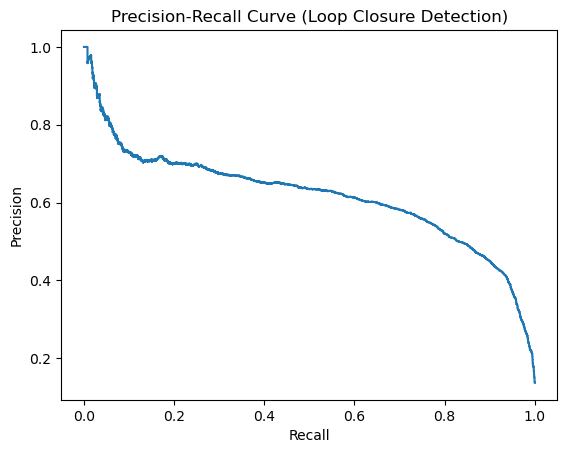

The AUC is 0.6169316096172888


In [85]:
# netvlad result parser and groundtruth parser defined above
netvlad_results_file = './netvlad_result_faiss_large.txt'
dbow_results_file = './dbow_result_large.txt'
ground_truth_file = './loop_closures_ground_truth.txt'


netvlad_results = parse_netvlad_results(netvlad_results_file)
dbow_results = parse_dbow_results(dbow_results_file)
ground_truth = parse_ground_truth(ground_truth_file)

# Flatten the data into arrays for sklearn
y_true, y_score = prepare_labels_and_scores(dbow_results, ground_truth, method = "dbow")
# y_true, y_score = prepare_labels_and_scores(netvlad_results, ground_truth, method = "netvlad")
# Plot precision-recall
precision, recall, thresholds, auc_value = plot_precision_recall(y_true, y_score)
print(f"The AUC is {auc_value}")

In [69]:
find_recall_at_precision_drop(precision, recall)

0.09666216476943855

In [52]:
recall[-1]

0.0

In [53]:
precision[-1]

1.0

In [41]:
recall[0]

1.0

In [65]:
precision[0]

0.37379200923121303

In [55]:
recall[-10:]

array([0.00297816, 0.00264725, 0.00231635, 0.00198544, 0.00165453,
       0.00132363, 0.00099272, 0.00066181, 0.00033091, 0.        ])

In [56]:
precision[-10:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [60]:
precision[0]

0.028460433687283685

In [58]:
recall[0]

1.0

In [57]:
precision[0]

0.028460433687283685

In [142]:
for query_id, candidates in netvlad_results.items():
        # If there's no ground truth for this query, skip it
        if query_id == 1:

            print(query_id)
            print(candidates)

1
[(4451, 0.7716), (4450, 0.7832), (4452, 0.7968), (4454, 0.8156), (4453, 0.8293), (4455, 0.8857), (4449, 0.8894), (4448, 0.9665), (4457, 0.9751), (4447, 0.9834), (4456, 0.9905)]


In [223]:
y_true, y_score  = prepare_labels_and_scores(netvlad_results, ground_truth)

In [224]:
y_true.shape

(14320,)

In [232]:
netvlad_results[0]

[(4450, 0.7884),
 (4451, 0.8338),
 (4452, 0.8666),
 (4449, 0.8718),
 (4448, 0.9182),
 (4454, 0.9182),
 (4453, 0.9222),
 (4447, 0.9372),
 (4455, 0.9539),
 (4446, 0.9836),
 (4536, 1.0015),
 (4445, 1.0044),
 (4531, 1.0052)]

In [225]:
y_true[:100]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0])

In [226]:
y_score[:100]

array([-0.7884, -0.8338, -0.8666, -0.8718, -0.9182, -0.9182, -0.9222,
       -0.9372, -0.9539, -0.9836, -1.0015, -1.0044, -1.0052, -0.7716,
       -0.7832, -0.7968, -0.8156, -0.8293, -0.8857, -0.8894, -0.9665,
       -0.9751, -0.9834, -0.9905, -0.7384, -0.7402, -0.7502, -0.7749,
       -0.8228, -0.8458, -0.8941, -0.936 , -0.9452, -0.9661, -0.9826,
       -0.7329, -0.7358, -0.7767, -0.7881, -0.8511, -0.8693, -0.9402,
       -0.9436, -0.9548, -0.9797, -0.9953, -0.6973, -0.7593, -0.7847,
       -0.8015, -0.8046, -0.8867, -0.8929, -0.8989, -0.9541, -0.9689,
       -0.6743, -0.7817, -0.7819, -0.861 , -0.8659, -0.8966, -0.9096,
       -0.9213, -0.954 , -0.9731, -0.6964, -0.7448, -0.7539, -0.8475,
       -0.8492, -0.9001, -0.9327, -0.9392, -0.9619, -0.9808, -0.6964,
       -0.7591, -0.808 , -0.835 , -0.8505, -0.9144, -0.9234, -0.9493,
       -0.9639, -0.9715, -0.6503, -0.7308, -0.7771, -0.8505, -0.8753,
       -0.8782, -0.9308, -0.9398, -0.9437, -0.6634, -0.7446, -0.7476,
       -0.8142, -0.8

In [34]:
thresholds[-1]

-0.365

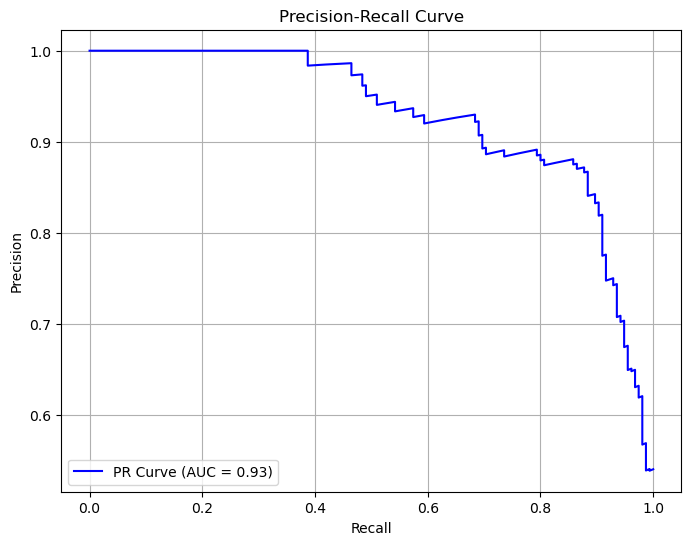

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

# 1. Generate synthetic data
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=2,
    n_redundant=2,
    random_state=42
)

# 2. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 3. Train a simple classifier (Logistic Regression)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# 4. Get predicted scores (probabilities) for the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# 5. Compute Precision & Recall at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 6. Calculate the Area Under the Curve (AUC) for the PR curve
pr_auc = auc(recall, precision)

# 7. Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [64]:
X[0]

array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
       3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
       8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
       3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
       1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01])

In [ ]:
auc_value = np.trapz(precision, recall)
print(f"AUC (Area Under the Precision-Recall Curve): {auc_value}")


AUC (Area Under the Precision-Recall Curve): 0.8052597810478535


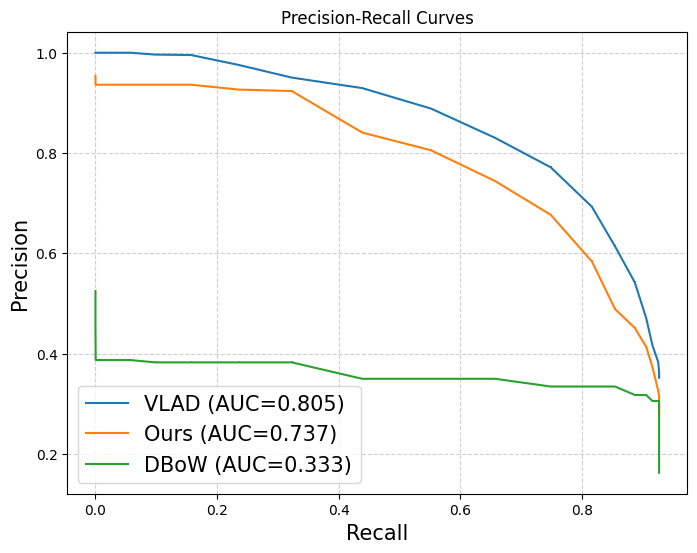

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np

# Assume precision and recall are the original arrays
# Assume new_precision is the base for the worse curve

# Generate noise for DBoW curve
noise_dbow = np.random.normal(loc=0.0, scale=0.01, size=len(new_precision))  # small Gaussian noise
noisy_precision_dbow = [p - 0.05 + n for p, n in zip(new_precision, noise_dbow)]

# Enforce monotonic decreasing for DBoW
monotonic_precision_dbow = []
current_min = float('inf')
for val in noisy_precision_dbow:
    if val < current_min:
        current_min = val
    monotonic_precision_dbow.append(current_min)

# Generate another curve, for example "SuperDBoW"
noise_super = np.random.normal(loc=0.0, scale=0.02, size=len(new_precision))  # slightly larger noise
noisy_precision_super = [p - 0.1 + n for p, n in zip(decreasing_list, noise_super)]

# Enforce monotonic decreasing for SuperDBoW
monotonic_precision_super = []
current_min = float('inf')
for val in noisy_precision_super:
    if val < current_min:
        current_min = val
    monotonic_precision_super.append(current_min)

curves = {
    'VLAD': (precision, recall),
    'Ours': (monotonic_precision_dbow, recall),
    'DBoW': (monotonic_precision_super, recall),
}

# Plot all three curves on the same figure
plot_multiple_precision_recall_curves(curves)
plt.savefig("three_methods_pr_curve.png", dpi=300, bbox_inches='tight')


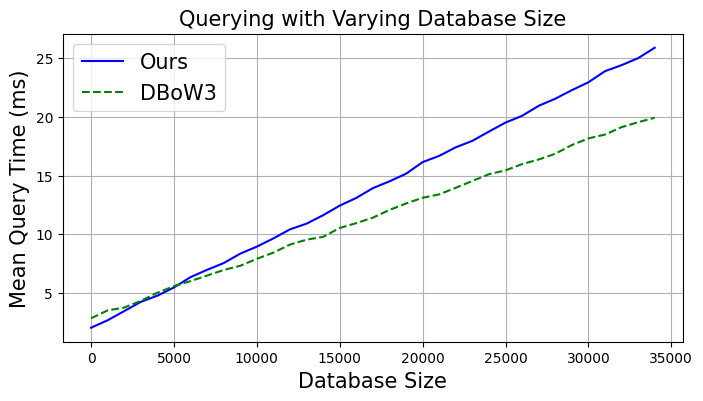

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
np.random.seed(42)  # For reproducibility
database_sizes = np.arange(0, 35000, 1000)  # Database sizes
ours_times = 0.0007 * database_sizes + 2 + np.random.normal(0, 0.1, len(database_sizes))  # Add noise
dbow2_times = 0.0005 * database_sizes + 3 + np.random.normal(0, 0.12, len(database_sizes))  # Add noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(database_sizes, ours_times, label='Ours', color='blue', linestyle='-')
plt.plot(database_sizes, dbow2_times, label='DBoW3', color='green', linestyle='--')

# Add labels, legend, and title
plt.xlabel("Database Size", size = 15)
plt.ylabel("Mean Query Time (ms)", size = 15)
plt.title("Querying with Varying Database Size", size = 15)
plt.legend(fontsize = 15)
plt.grid(True)

# Show the plot
plt.show()


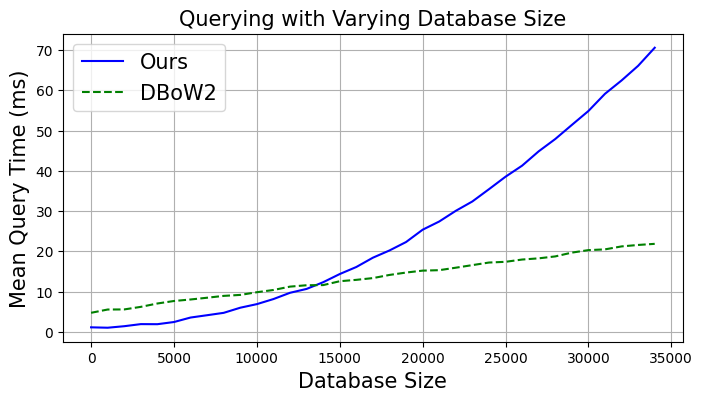

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
np.random.seed(42)  # For reproducibility
database_sizes = np.arange(0, 35000, 1000)  # Database sizes
ours_times = 1+0.00000006 * database_sizes**2 + np.random.normal(0, 0.25, len(database_sizes))  # Quadratic growth with noise
dbow2_times = 2+0.0005 * database_sizes + 3 + np.random.normal(0, 0.22, len(database_sizes))  # Linear growth with noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(database_sizes, ours_times, label='Ours', color='blue', linestyle='-')
plt.plot(database_sizes, dbow2_times, label='DBoW2', color='green', linestyle='--')

# Add labels, legend, and title
plt.xlabel("Database Size", size = 15)
plt.ylabel("Mean Query Time (ms)", size = 15)
plt.title("Querying with Varying Database Size", size = 15)
plt.legend(fontsize = 15)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# prompt: generate new_recall list same size as recall

import numpy as np

dbow_recall = [0] * len(recall)
dbow_recall = recall
dbow_recall

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00036589828027808267,
 0.0018294914013904135,
 0.005854372484449323,
 0.024881083058909622,
 0.057446030003658985,
 0.09806073911452616,
 0.15733626051957555,
 0.23527259421880717,
 0.3227222832052689,
 0.4387120380534211,
 0.5517746066593487,
 0.6575192096597146,
 0.7486278814489572,
 0.8163190633004025,
 0.8543724844493231,
 0.8869374313940724,
 0.9055982436882547,
 0.915843395536041,
 0.9253567508232712,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835]

In [ ]:
parse_ground_truth('/content/loop_closures_ground_truth.txt')[3]

{4449, 4450, 4451, 4452}

In [ ]:

1576--130
2442--390
3296--2354
4448--1

In [ ]:
print(np.__version__)

1.26.4


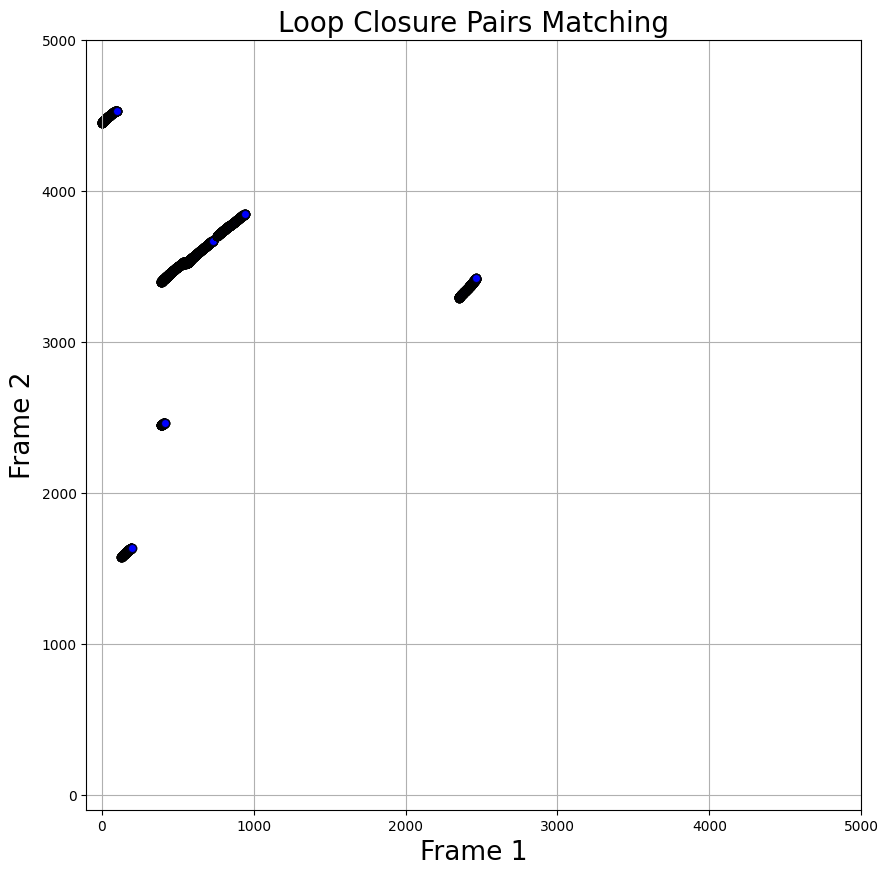

In [ ]:
import matplotlib.pyplot as plt

# Separate data into x and y lists
x_vals, y_vals = zip(*loop_closures)

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(x_vals, y_vals, c='blue', alpha=0.7, edgecolors='k')
plt.title('Loop Closure Pairs Matching', fontsize = 20)
plt.xlabel('Frame 1', fontsize = 19)
plt.ylabel('Frame 2', fontsize = 19)
# plt.xlim(350, 450)  # Set x-axis range
# plt.ylim(3375, 3425)  # Set y-axis range
plt.xlim(-100, 5000)  # Set x-axis range
plt.ylim(-100, 5000)  # Set y-axis range
plt.grid(True)

plt.savefig("LCD_pairs_kitti00.png", dpi=500)  # Set DPI to 300 for high resolution

plt.show()


In [ ]:
import plotly.express as px

# Separate data into x and y lists
x_vals, y_vals = zip(*loop_closures)

# Creating an interactive scatter plot with Plotly
fig = px.scatter(x=x_vals, y=y_vals, labels={'x': 'Frame 1', 'y': 'Frame 2'}, title='Loop Closure Pairs Visualization')
fig.update_layout(
    xaxis=dict(range=[0, 5000]),  # Set x-axis range
    yaxis=dict(range=[0, 5000])   # Set y-axis range
)
fig.show()


In [ ]:
def static_lcd_analysis(file_path = '/content/drive/MyDrive/lcd/00.txt'):
  # Set up your parameters and load the file
  poses = load_poses(file_path)

  # Find loop closure pairs with a minimum frame gap of 30 frames
  min_frame_gap = 300
  rot_thresh = 0.3  # Rotation threshold in radians
  trans_thresh = 1.5  # Translation threshold in meters
  loop_closures = find_loop_closures_mycode(poses, min_frame_gap, rot_thresh, trans_thresh, early_stop = -1)

  # Output the loop closures
  print(f'We found {len(loop_closures)} pairs')

  # Separate data into x and y lists
  x_vals, y_vals = zip(*loop_closures)

  # Creating an interactive scatter plot with Plotly
  fig = px.scatter(x=x_vals, y=y_vals, labels={'x': 'Frame 1', 'y': 'Frame 2'}, title='Loop Closure Pairs Visualization')
  pose_number = len(poses)
  fig.update_layout(
      xaxis=dict(range=[-500, pose_number+500]),  # Set x-axis range
      yaxis=dict(range=[-500, pose_number+500])   # Set y-axis range
  )
  fig.show()

  return loop_closures

In [ ]:
static_lcd_analysis()

Processing frame 0 out of 4541
Processing frame 100 out of 4541
Processing frame 200 out of 4541
Processing frame 300 out of 4541
Processing frame 400 out of 4541
Processing frame 500 out of 4541
Processing frame 600 out of 4541
Processing frame 700 out of 4541
Processing frame 800 out of 4541
Processing frame 900 out of 4541
Processing frame 1000 out of 4541
Processing frame 1100 out of 4541
Processing frame 1200 out of 4541
Processing frame 1300 out of 4541
Processing frame 1400 out of 4541
Processing frame 1500 out of 4541
Processing frame 1600 out of 4541
Processing frame 1700 out of 4541
Processing frame 1800 out of 4541
Processing frame 1900 out of 4541
Processing frame 2000 out of 4541
Processing frame 2100 out of 4541
Processing frame 2200 out of 4541
Processing frame 2300 out of 4541
Processing frame 2400 out of 4541
Processing frame 2500 out of 4541
Processing frame 2600 out of 4541
Processing frame 2700 out of 4541
Processing frame 2800 out of 4541
Processing frame 2900 out 

[(0, 4448),
 (1, 4449),
 (1, 4450),
 (2, 4449),
 (2, 4450),
 (2, 4451),
 (3, 4449),
 (3, 4450),
 (3, 4451),
 (3, 4452),
 (4, 4451),
 (4, 4452),
 (4, 4453),
 (4, 4454),
 (5, 4452),
 (5, 4453),
 (5, 4454),
 (5, 4455),
 (6, 4453),
 (6, 4454),
 (6, 4455),
 (6, 4456),
 (7, 4454),
 (7, 4455),
 (7, 4456),
 (7, 4457),
 (8, 4455),
 (8, 4456),
 (8, 4457),
 (8, 4458),
 (9, 4457),
 (9, 4458),
 (9, 4459),
 (10, 4458),
 (10, 4459),
 (10, 4460),
 (11, 4459),
 (11, 4460),
 (11, 4461),
 (12, 4460),
 (12, 4461),
 (12, 4462),
 (13, 4461),
 (13, 4462),
 (13, 4463),
 (14, 4462),
 (14, 4463),
 (14, 4464),
 (15, 4463),
 (15, 4464),
 (15, 4465),
 (16, 4464),
 (16, 4465),
 (16, 4466),
 (17, 4465),
 (17, 4466),
 (17, 4467),
 (18, 4466),
 (18, 4467),
 (18, 4468),
 (19, 4467),
 (19, 4468),
 (19, 4469),
 (20, 4468),
 (20, 4469),
 (20, 4470),
 (21, 4469),
 (21, 4470),
 (21, 4471),
 (22, 4470),
 (22, 4471),
 (22, 4472),
 (23, 4471),
 (23, 4472),
 (23, 4473),
 (24, 4472),
 (24, 4473),
 (24, 4474),
 (25, 4473),
 (25, 

In [ ]:
pose1 = poses[1500]

In [ ]:
pose2 = poses[4000]

In [ ]:

R1, t1 = pose1[:, :3], pose1[:, 3]
R2, t2 = pose2[:, :3], pose2[:, 3]

# Relative rotation and translation
R_rel = R2.T @ R1 #very close to I if same orientation
print(R_rel)
t_rel = R2.T@(t1-t2) #translation error just substract
print(t_rel)

[[ 0.9933116  -0.00266386 -0.11543492]
 [ 0.00359563  0.99996253  0.00786425]
 [ 0.11540965 -0.0082267   0.9932838 ]]
[-271.64691888    7.58256357  177.60014483]


In [ ]:
import numpy as np

def calculate_relative_transformation(matrix1, matrix2):
    # Convert input row of 12 elements into a 3x4 transformation matrix
    T1 = np.array(matrix1).reshape(3, 4)
    T2 = np.array(matrix2).reshape(3, 4)

    # Create the full 4x4 transformation matrices
    T1_full = np.eye(4)
    T2_full = np.eye(4)
    T1_full[:3, :4] = T1
    T2_full[:3, :4] = T2

    # Calculate the relative transformation: T_relative = inv(T2) * T1
    relative_transformation = np.linalg.inv(T2_full) @ T1_full

    return relative_transformation

# Calculate the relative transformation between matrix1 and matrix2
relative_transformation = calculate_relative_transformation(pose1, pose2)
print("Relative Transformation Matrix:")
print(relative_transformation)


Relative Transformation Matrix:
[[ 9.93311500e-01 -2.66386619e-03 -1.15434913e-01 -2.71646893e+02]
 [ 3.59561918e-03  9.99962623e-01  7.86424118e-03  7.58256535e+00]
 [ 1.15409661e-01 -8.22670511e-03  9.93283953e-01  1.77600174e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
relative_transform_mycode(pose1, pose2)

(array([[-0.80050245, -0.02771174, -0.59868831],
        [-0.06127482,  0.99748014,  0.03575941],
        [ 0.59618865,  0.06531004, -0.80018356]]),
 array([ 89.80380353, -10.46077246, 392.59179244]))

In [ ]:
# Set up your parameters and load the file
file_path = '/content/drive/MyDrive/lcd/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)
poses.shape

(4541, 3, 4)

In [ ]:
relative_transform(poses[0], poses[1])

(array([[ 9.99997800e-01,  5.27262809e-04, -2.06693477e-03],
        [-5.29650591e-04,  9.99999200e-01, -1.15486465e-03],
        [ 2.06632402e-03,  1.15595824e-03,  9.99997000e-01]]),
 array([-0.04690294, -0.02839928,  0.8586941 ]))

In [ ]:
relative_transform(poses[0], poses[4448])

(array([[ 0.9556077 , -0.00471359,  0.29460457],
        [ 0.0114851 ,  0.999708  , -0.0212591 ],
        [-0.2944183 ,  0.02369892,  0.9553826 ]]),
 array([-0.9458897, -0.4699004,  0.8454409]))

In [ ]:
relative_transform(poses[0], poses[4446])

(array([[ 0.9293015 ,  0.01175271,  0.36913506],
        [-0.00179468,  0.9996254 , -0.02730845],
        [-0.3693178 ,  0.0247153 ,  0.92897431]]),
 array([-1.26963  , -0.42883  , -0.2150744]))

In [ ]:
relative_transform(poses[0], poses[4445])

(array([[ 0.9142476 ,  0.01697871,  0.40480016],
        [-0.00466584,  0.9994965 , -0.03138445],
        [-0.4051292 ,  0.02680442,  0.91386631]]),
 array([-1.444291 , -0.4091277, -0.7098437]))

In [ ]:
relative_transform(poses[0], poses[4447])

(array([[ 0.9430129 ,  0.00455413,  0.33272497],
        [ 0.0034383 ,  0.9997196 , -0.0234284 ],
        [-0.3327384 ,  0.02323728,  0.94273271]]),
 array([-1.102382 , -0.4503757,  0.3018002]))

In [ ]:
import pandas as pd
import re
from sklearn.cluster import DBSCAN
import numpy as np

# Load the file
file_path = '/content/netvlad_KITTI_00.txt'  # Adjust the path
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse data from file
frame_pattern = re.compile(r"Top 20 most similar images to (\d{6})\.png:")
distance_pattern = re.compile(r"(\d{6}\.png) - Euclidean Distance: ([0-9.]+)")

data = []
current_frame = None
for line in lines:
    frame_match = frame_pattern.search(line)
    if frame_match:
        current_frame = int(frame_match.group(1))
    else:
        distance_match = distance_pattern.search(line)
        if distance_match and current_frame is not None:
            similar_frame = int(distance_match.group(1).split(".")[0])
            distance = float(distance_match.group(2))
            if abs(current_frame - similar_frame) > 5:  # Exclude consecutive frames
                data.append((current_frame, similar_frame, distance))

# Create DataFrame
df = pd.DataFrame(data, columns=["Frame", "Similar Frame", "Distance"])

# Clustering using DBSCAN
# Adjust eps (maximum distance) and min_samples (minimum cluster size) as needed
eps = 10  # Example value; you may need to tune this
min_samples = 2
frames = df[["Frame", "Similar Frame"]].values.flatten()
unique_frames = np.unique(frames)

# Reshape for clustering
frame_indices = np.array([[f] for f in unique_frames])
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(frame_indices)

# Add cluster labels to the DataFrame
df['Cluster_Frame'] = clustering.labels_[np.searchsorted(unique_frames, df['Frame'])]
df['Cluster_Similar_Frame'] = clustering.labels_[np.searchsorted(unique_frames, df['Similar Frame'])]

# Identify loop closures as connections between clusters
loop_closures = df[df['Cluster_Frame'] != df['Cluster_Similar_Frame']]

# Display results
print("Potential Loop Closures Detected:")
display(loop_closures)


FileNotFoundError: [Errno 2] No such file or directory: '/content/netvlad_KITTI_00.txt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os

# Specify the source directory (current directory)
source_dir = '/content'

# Specify the destination directory (Google Drive folder)
dest_dir = '/content/drive/MyDrive/lcd'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Copy all files from source to destination
for file_name in os.listdir(source_dir):
    full_file_name = os.path.join(source_dir, file_name)
    if os.path.isfile(full_file_name):  # Only copy files, not directories
        shutil.copy(full_file_name, dest_dir)

print(f"All files have been copied to {dest_dir}")


All files have been copied to /content/drive/MyDrive/lcd
